<a href="https://colab.research.google.com/github/pedrinhong/CIS/blob/main/PERIODO_5_CIS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow

     |████████████████████████████████| 462 kB 5.2 MB/s 


In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Activation, MaxPool2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_accuracy, categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, f1_score
import itertools
import os
import shutil
import random
import glob
from matplotlib import pyplot as plt
import warnings
warnings.simplefilter(action = "ignore", category = FutureWarning)
%matplotlib inline

Primeiro passo: manipulando diretórios e seus respectivos conteúdos e ,em seguida, pré-processando as imagens.

Antes de tudo, conferindo se o tensorflow está corretamente usando a GPU. Aparentemente, como estou usando o Collab, minha GPU nao é diretamente usada.

In [2]:
physical_devices = tf.config.experimental.list_physical_devices("GPU")
print(f"There are {physical_devices} GPUs availables!")
if physical_devices:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
else:
  print("Once there are no GPUs being used, there is no way of setting memory growth!")

There are [] GPUs availables!
Once there are no GPUs being used, there is no way of setting memory growth!


Identificando o atual diretorio.

In [3]:
cwd = os.getcwd()  # Get the current working directory (cwd)
files = os.listdir(cwd)  # Get all the files in that directory
print(f" The files in the current working directory({cwd}) are: {files}")

 The files in the current working directory(/content) are: ['.config', 'drive', 'sample_data']


Mudando para o diretorio desejado no drive.

In [4]:
os.chdir(r'drive')
os.chdir(r'MyDrive')
os.chdir(r'cats-vs-dogs')
os.chdir(r'train')

In [ ]:
cwd = os.getcwd()  # Get the current working directory (cwd)
files = os.listdir(cwd)  # Get all the files in that directory
print(f" The files in the current working directory({cwd}) are: {files}")

Criando os diretórios de treino, validacao e teste.

In [5]:
if not os.path.isdir('train/dog'):
  os.makedirs('train/dog')
if not os.path.isdir('train/cat'):
  os.makedirs('train/cat')
if not os.path.isdir('validate/dog'):
  os.makedirs('validate/dog')
if not os.path.isdir('validate/cat'):
  os.makedirs('validate/cat')
if not os.path.isdir('test/dog'):
  os.makedirs('test/dog')
if not os.path.isdir('test/cat'):
  os.makedirs('test/cat')

Movendo as imagens - escolhidas aleatoriamente - para os respectivos diretorios.

In [ ]:
for image in random.sample(glob.glob('dog*'), 500):
  shutil.move(image, 'train/dog')

In [ ]:
for image in random.sample(glob.glob('dog*'), 500):
  shutil.move(image, 'train/dog')

In [ ]:
for image in random.sample(glob.glob('cat*'), 500):
  shutil.move(image, 'train/cat')

In [ ]:
for image in random.sample(glob.glob('dog*'), 100):
  shutil.move(image, 'validate/dog')

In [ ]:
for image in random.sample(glob.glob('cat*'), 100):
  shutil.move(image, 'validate/cat')

In [ ]:
for image in random.sample(glob.glob('dog*'), 50):
  shutil.move(image, 'test/dog')

In [ ]:
for image in random.sample(glob.glob('cat*'), 50):
  shutil.move(image, 'test/cat')

In [ ]:
print(f"The current working directory is: {os.getcwd()}")

The current working directory is: /content/drive/MyDrive/cats-vs-dogs/train


Retornando para o inicio dos diretorios aninhados.

In [6]:
os.chdir('..')
os.chdir('..')
os.chdir('..')

In [7]:
print(f"The current working directory is: {os.getcwd()}")

The current working directory is: /content/drive


Especificando o caminho para cada um dos diretorios de onde as imagens serao retiradas.

In [8]:
train_path = 'MyDrive/cats-vs-dogs/train/train'
validate_path = 'MyDrive/cats-vs-dogs/train/validate'
test_path = 'MyDrive/cats-vs-dogs/train/test'

Agora, as imagens serao pré-processadas e depois visualizadas.

In [9]:
train_batches = ImageDataGenerator(preprocessing_function = tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory = train_path, target_size = (224,224), classes = ["dog","cat"], batch_size = 10)
validate_batches = ImageDataGenerator(preprocessing_function = tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory = validate_path, target_size = (224,224), classes = ["dog","cat"], batch_size = 10)
test_batches = ImageDataGenerator(preprocessing_function = tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory = test_path, target_size = (224,224), classes = ["dog","cat"], batch_size = 10, shuffle = False)

Found 1000 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


Aceesando o primeiro batch.

In [10]:
images, labels = next(train_batches)

Como esperado, sabendo que: 
- o input das CNN sao numpy arrays com os valores de cada pixel das imagens.
- sao 10 imagens por batch.
- as imagens foram remodeladas para tamanho 224x224.
- como as imagens sao coloridas, há três canais - RGB.

In [11]:
print(f"The images have type: {type(images)}")
print(f"The images have : {images.shape}")

The images have type: <class 'numpy.ndarray'>
The images have : (10, 224, 224, 3)


Podemos perceber também que o output está no formato de OneHotEncoded, ou seja, cada uma das colunas representa uma classe - a primeira representa cat e a segunda dog.

In [12]:
print(f"The labels have type: {type(labels)}")
for label in labels:
  print(label)

The labels have type: <class 'numpy.ndarray'>
[0. 1.]
[1. 0.]
[1. 0.]
[1. 0.]
[0. 1.]
[1. 0.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]


Definindo funçao para visualizar as imagens.

In [13]:
def plotImagesBatch(images_array):
  flg, axes = plt.subplots(1, 10, figsize = (20,20)) # será um único plot com 10 subplots de dimensoes 10x10
  axes = axes.flatten()
  for image, ax in zip(images_array, axes):
    ax.imshow(image)
    ax.axis('off')
  plt.title("IMAGES OF FIRST BATCH")
  plt.tight_layout()
  plt.show()

E agora pode-se efetivamente visualizar as imagens. Além disso, as imagens estao visivelmente modificadas, uma vez que elas passaram por um pré-processamento.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

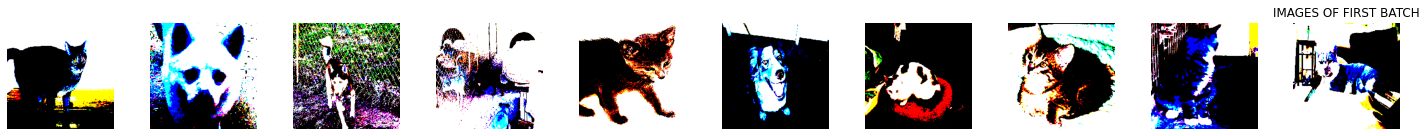

In [14]:
plotImagesBatch(images)

Agora, podemos realmente criar um modelo e treiná-lo.

Primeiro, cria-se o modelo.

In [19]:
model = Sequential([
    Conv2D(input_shape = (224,224,3), filters = 32, kernel_size = (3,3), strides = 1, padding = 'same'),
    Activation("relu"),
    MaxPool2D(pool_size = (2,2), strides= 2),
    Conv2D(filters = 64, kernel_size = (3,3), strides = 1, padding = 'same'),
    Activation("relu"),
    MaxPool2D(pool_size = (2,2), strides= 2),
    Flatten(),
    Dense(units = 2),
    Activation("softmax")
])
# Conv2D(filters = 128, kernel_size = (4,4), strides = 1, padding = 'same'),
# Activation("relu"),

E podemos visualizar a NN e as relaçoes de input e output de cada layer.

In [20]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 activation_8 (Activation)   (None, 224, 224, 32)      0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 activation_9 (Activation)   (None, 112, 112, 64)      0         
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                  

Agora, o modelo é compilado.

In [ ]:
model.compile(loss = "categorical_crossentropy", metrics = ["accuracy"], optimizer = Adam(learning_rate = 0.0001))

E finalmente, treiná-lo.

In [ ]:
model.fit(x = train_batches, validation_data = validate_batches, epochs = 10, verbose = 2)

Epoch 1/10
100/100 - 130s - loss: 17.3369 - accuracy: 0.5660 - val_loss: 4.9263 - val_accuracy: 0.5950 - 130s/epoch - 1s/step
Epoch 2/10
100/100 - 73s - loss: 2.6727 - accuracy: 0.7490 - val_loss: 3.2179 - val_accuracy: 0.6350 - 73s/epoch - 730ms/step
Epoch 3/10
100/100 - 73s - loss: 0.9084 - accuracy: 0.8680 - val_loss: 2.4801 - val_accuracy: 0.6750 - 73s/epoch - 725ms/step
Epoch 4/10
100/100 - 72s - loss: 0.3704 - accuracy: 0.9270 - val_loss: 2.9055 - val_accuracy: 0.6250 - 72s/epoch - 724ms/step
Epoch 5/10
100/100 - 72s - loss: 0.2581 - accuracy: 0.9500 - val_loss: 2.6808 - val_accuracy: 0.6650 - 72s/epoch - 722ms/step
Epoch 6/10
100/100 - 72s - loss: 0.1371 - accuracy: 0.9700 - val_loss: 2.8313 - val_accuracy: 0.6450 - 72s/epoch - 722ms/step
Epoch 7/10
100/100 - 76s - loss: 0.0142 - accuracy: 0.9970 - val_loss: 2.5257 - val_accuracy: 0.6750 - 76s/epoch - 762ms/step
Epoch 8/10
100/100 - 73s - loss: 0.0099 - accuracy: 0.9970 - val_loss: 3.0260 - val_accuracy: 0.6550 - 73s/epoch - 730

Percebe-se claramente que houve overfitting, uma vez as acuracias iniciais nos dataset de treino e validacao sao as mesmas e ,ao passar das épocas, a acuracia no dataset de treino apresentou extremo crescimento e enquanto a acuracia no dataset de validacao nao apresentou crescimento proporcional simultaneamente.
Logo, deve-se adaptar o modelo tendo como objetivo minimizar o overfitting.

In [35]:
model = Sequential([
    Conv2D(input_shape = (224,224,3), filters = 32, kernel_size = (3,3), strides = 1, padding = 'same'),
    Activation("relu"),
    MaxPool2D(pool_size = (2,2), strides= 2),
    Dropout(0.1),
    Conv2D(filters = 64, kernel_size = (3,3), strides = 1, padding = 'same'),
    Activation("relu"),
    MaxPool2D(pool_size = (2,2), strides= 2),
    Dropout(0.1),
    Conv2D(filters = 128, kernel_size = (3,3), strides = 1, padding = 'same'),
    Activation("relu"),
    Flatten(),
    Dropout(0.1),
    Dense(units = 2),
    Activation("softmax")
])

In [36]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_29 (Conv2D)          (None, 224, 224, 32)      896       
                                                                 
 activation_39 (Activation)  (None, 224, 224, 32)      0         
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 112, 112, 32)     0         
 g2D)                                                            
                                                                 
 dropout_26 (Dropout)        (None, 112, 112, 32)      0         
                                                                 
 conv2d_30 (Conv2D)          (None, 112, 112, 64)      18496     
                                                                 
 activation_40 (Activation)  (None, 112, 112, 64)      0         
                                                     

In [37]:
model.compile(loss = "categorical_crossentropy", metrics = ["accuracy"], optimizer = Adam(learning_rate = 0.0001))

Percebe-se que o modelo apresenta mais overfitting, porém sua performance também nao melhorou.

In [38]:
model.fit(x = train_batches, validation_data = validate_batches, epochs = 20, verbose = 2)

Epoch 1/20
100/100 - 113s - loss: 8.7627 - accuracy: 0.5440 - val_loss: 1.2056 - val_accuracy: 0.6000 - 113s/epoch - 1s/step
Epoch 2/20
100/100 - 112s - loss: 0.7452 - accuracy: 0.7420 - val_loss: 1.1124 - val_accuracy: 0.5750 - 112s/epoch - 1s/step
Epoch 3/20
100/100 - 112s - loss: 0.3807 - accuracy: 0.8350 - val_loss: 0.8189 - val_accuracy: 0.5950 - 112s/epoch - 1s/step
Epoch 4/20
100/100 - 112s - loss: 0.1830 - accuracy: 0.9260 - val_loss: 0.8439 - val_accuracy: 0.6100 - 112s/epoch - 1s/step
Epoch 5/20
100/100 - 112s - loss: 0.1538 - accuracy: 0.9420 - val_loss: 0.9032 - val_accuracy: 0.6200 - 112s/epoch - 1s/step
Epoch 6/20
100/100 - 112s - loss: 0.0815 - accuracy: 0.9770 - val_loss: 0.9367 - val_accuracy: 0.6000 - 112s/epoch - 1s/step
Epoch 7/20
100/100 - 112s - loss: 0.0765 - accuracy: 0.9750 - val_loss: 0.9872 - val_accuracy: 0.5900 - 112s/epoch - 1s/step
Epoch 8/20
100/100 - 112s - loss: 0.0483 - accuracy: 0.9860 - val_loss: 1.0688 - val_accuracy: 0.5900 - 112s/epoch - 1s/step


In [ ]:
predictions = model.predict(x = test_batches, verbose = 0)
predictions

array([[9.99429166e-01, 5.70819306e-04],
       [4.25282195e-02, 9.57471728e-01],
       [9.99701321e-01, 2.98660656e-04],
       [1.09686494e-01, 8.90313506e-01],
       [1.87858626e-01, 8.12141359e-01],
       [1.01420470e-02, 9.89857972e-01],
       [9.98689711e-01, 1.31024932e-03],
       [9.78910387e-01, 2.10896246e-02],
       [1.00690745e-01, 8.99309218e-01],
       [9.94370639e-01, 5.62935509e-03],
       [9.98424172e-01, 1.57579116e-03],
       [9.99844670e-01, 1.55281319e-04],
       [9.99979377e-01, 2.05786491e-05],
       [2.04363815e-03, 9.97956395e-01],
       [9.38895643e-01, 6.11044131e-02],
       [9.26644027e-01, 7.33559728e-02],
       [9.26079694e-03, 9.90739226e-01],
       [1.00000000e+00, 1.98342545e-16],
       [4.97046083e-01, 5.02953947e-01],
       [9.99994278e-01, 5.77393530e-06],
       [2.29867408e-03, 9.97701347e-01],
       [9.99824226e-01, 1.75776077e-04],
       [9.96597707e-01, 3.40232323e-03],
       [9.40646768e-01, 5.93532510e-02],
       [3.412201

In [ ]:
y_pred = np.argmax(predictions, axis = 1)
y_pred

array([0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

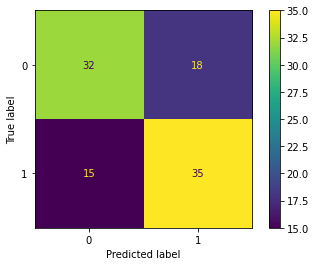

In [ ]:
c_matrix = confusion_matrix(y_true = test_batches.classes, y_pred = y_pred)
ConfusionMatrixDisplay(confusion_matrix = c_matrix).plot()